In [1]:
import os
import numpy as np
import pandas as pd
from collections import deque

!pip install music21
!pip install pygame

from music21 import converter, instrument, note, chord, bar, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Using TensorFlow backend.


In [2]:
# grab / parse data

In [70]:
midi_directory = "midi/Piano_2h"
# specify the number of track in each song (should be the same, in same order, for each song)
tracks = (0, 1)
instru = instrument.Piano()

notes = [[] for track in tracks]
durations = [[] for track in tracks]
offsets = [[] for track in tracks]
velocities = [[] for track in tracks]
for i, file in enumerate(os.listdir(midi_directory)):
    midi_part = converter.parse(os.path.join(midi_directory, file))
    # Parse the midi file by the notes/chords it contains
    for track, _ in enumerate(tracks):
        notes_to_parse = midi_part[tracks[track]].flat.notesAndRests
        last_offset = 0
        for elem in notes_to_parse:
            if isinstance(elem, note.Note):
                notes[track].append([str(elem.pitch)])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(elem.volume.velocity)
            elif isinstance(elem, chord.Chord):
                notes[track].append([str(n.nameWithOctave) for n in elem.pitches])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(elem.volume.velocity)
            elif isinstance(elem, note.Rest):
                notes[track].append([elem.name])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(0)
            last_offset = elem.offset
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 
# Get all notes
np_notes = [np.array(notes[track]) for track in tracks]
np_notes = [np_notes[track].flatten() for track in tracks]
notes_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for item in np_notes[track]:
        if len(item) > 1 and item != "rest":
            notes_vocab[track].append(",".join([note for note in item]))
        else:
            notes_vocab[track].append(item[0])
    notes_vocab[track] = sorted(set(notes_vocab[track]))
# Get all durations
durations_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    durations_vocab[track] = sorted(set(durations[track]))
# Get all offsets
offsets_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    offsets_vocab[track] = sorted(set(offsets[track]))
# Get all velocities
velocities_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    velocities_vocab[track] = sorted(set(velocities[track]))
    
for track, _ in enumerate(tracks):
    print("%s Notes, notes_Vocab : %s ; durations_Vocab : %s ; offsets_vocab : %s ; velocities_vocab : %s" % 
          (len(notes[track]), len(notes_vocab[track]), len(durations_vocab[track]), len(offsets_vocab[track]), len(velocities[track])))
print(notes_vocab, notes)
print(durations_vocab, durations)
print(offsets_vocab, offsets)
print(velocities_vocab, velocities)

Song Bach_2PartInv_No1_in_C_BWV772.mid Loaded
Song Bach_2PartInv_No8_in_F_BWV779.mid Loaded
Song be_son1a.mid Loaded
Song be_son1b.mid Loaded
Song be_son1c.mid Loaded
Song be_son1d.mid Loaded
Song gigue.mid Loaded
Song gigue1.mid Loaded
Song sonat-1.mid Loaded
Song sonat-2.mid Loaded
Song sonat-8.mid Loaded
Song sonat-9.mid Loaded
DONE LOADING SONGS
7758 Notes, notes_Vocab : 199 ; durations_Vocab : 40 ; offsets_vocab : 55 ; velocities_vocab : 7758
8136 Notes, notes_Vocab : 205 ; durations_Vocab : 30 ; offsets_vocab : 55 ; velocities_vocab : 8136
[['A2', 'A3', 'A3,A4', 'A3,C4,F4', 'A3,F4', 'A4', 'A4,C#5', 'A4,C5', 'A4,C5,F5', 'A4,D5', 'A4,F5', 'A4,G5', 'A5', 'A5,F5', 'B-3', 'B-3,B-4', 'B-3,E4', 'B-3,G4', 'B-4', 'B-4,B-5', 'B-4,C#5', 'B-4,C#5,B-5', 'B-4,C#5,F5', 'B-4,D5', 'B-4,E-5', 'B-4,E5', 'B-4,E5,G5,B-5', 'B-4,F5', 'B-4,G5', 'B-5', 'B2', 'B3', 'B3,B4', 'B3,C4', 'B3,D4', 'B3,D4,F4,G#4,B4', 'B4', 'B4,B5', 'B4,D5', 'B4,D5,F5,G#5,B5', 'B4,D5,G5,B5', 'B4,F5', 'B5', 'B5,C6', 'C#3', 'C#4', 

In [34]:
# turn notes to integers:

In [71]:
cat_notes = [[] for track in tracks]
cat_durations = [[] for track in tracks]
cat_offsets = [[] for track in tracks]
cat_velocities = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in notes[track]:
        int_note = notes_vocab[track].index(",".join(elem))
        cat = np.zeros((len(notes_vocab[track])))
        cat[int_note] = 1
        cat_notes[track].append(cat)
    for elem in durations[track]:
        int_duration = durations_vocab[track].index(elem)
        cat = np.zeros((len(durations_vocab[track])))
        cat[int_duration] = 1
        cat_durations[track].append(cat)
    for elem in offsets[track]:
        int_offset = offsets_vocab[track].index(elem)
        cat = np.zeros((len(offsets_vocab[track])))
        cat[int_offset] = 1
        cat_offsets[track].append(cat)
    for elem in velocities[track]:
        int_velocity = velocities_vocab[track].index(elem)
        cat = np.zeros((len(velocities_vocab[track])))
        cat[int_velocity] = 1
        cat_velocities[track].append(cat)
# merge
x = [cat_notes, cat_durations, cat_offsets, cat_velocities]

In [72]:
# Build generator

In [73]:
seq_len = 32
batch_size = 32
#split = int(0.8 * len(x))

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
    def __len__(self):
        return len(self.x[0][0]) // self.batch_size - 1
    def __getitem__(self, idx):
        
        X_note = [[] for track in tracks]
        X_duration = [[] for track in tracks]
        X_offset = [[] for track in tracks]
        X_velocity = [[] for track in tracks]
        
        Y_note = [[] for track in tracks]
        Y_duration = [[] for track in tracks]
        Y_offset = [[] for track in tracks]
        Y_velocity = [[] for track in tracks]
        
        res = [[], []]
        for track, _ in enumerate(tracks):
            for i in range(self.batch_size):
                
                X_note[track].append(self.x[0][track][idx+i : idx+i + seq_len])
                X_duration[track].append(self.x[1][track][idx+i : idx+i + seq_len])
                X_offset[track].append(self.x[2][track][idx+i : idx+i + seq_len])
                X_velocity[track].append(self.x[3][track][idx+i : idx+i + seq_len])
                
                Y_note[track].append(self.x[0][track][idx+i + seq_len])
                Y_duration[track].append(self.x[1][track][idx+i + seq_len])
                Y_offset[track].append(self.x[2][track][idx+i + seq_len])
                Y_velocity[track].append(self.x[3][track][idx+i + seq_len])
            
            X_note[track] = np.array(X_note[track])
            X_duration[track] = np.array(X_duration[track])
            X_offset[track] = np.array(X_offset[track])
            X_velocity[track] = np.array(X_velocity[track])
            
            Y_note[track] = np.array(Y_note[track])
            Y_duration[track] = np.array(Y_duration[track])
            Y_offset[track] = np.array(Y_offset[track])
            Y_velocity[track] = np.array(Y_velocity[track])
            
            res[0].append(X_note[track])
            res[0].append(X_duration[track])
            res[0].append(X_offset[track])
            res[0].append(X_velocity[track])
            
            res[1].append(Y_note[track])
            res[1].append(Y_duration[track])
            res[1].append(Y_offset[track])
            res[1].append(Y_velocity[track])
            
        return res
data_gen = dataGenerator(x, batch_size)

In [74]:
data_gen[0][0][0][0].shape

(32, 199)

In [66]:
# Build Model

In [75]:
K.clear_session()

inputs_list = []
tracks_list = []
outputs_list = []

for track, _ in enumerate(tracks):
    in_note = Input(shape=(seq_len, len(notes_vocab[track])))
    inputs_list.append(in_note)
    x1 = Bidirectional(LSTM(32))(in_note)
    tracks_list.append(x1)
    
    in_duration = Input(shape=(seq_len, len(durations_vocab[track])))
    inputs_list.append(in_duration)
    x2 = Bidirectional(LSTM(32))(in_duration)
    tracks_list.append(x2)

    in_offset = Input(shape=(seq_len, len(offsets_vocab[track])))
    inputs_list.append(in_offset)
    x3 = Bidirectional(LSTM(32))(in_offset)
    tracks_list.append(x3)
    
    in_velocity = Input(shape=(seq_len, len(velocities_vocab[track])))
    inputs_list.append(in_velocity)
    x4 = Bidirectional(LSTM(32))(in_velocity)
    tracks_list.append(x4)

concat = Concatenate()(tracks_list)
shared = Dense(64, activation='relu')(concat)

for track, _ in enumerate(tracks):
    out_note = Dense(len(notes_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_note)
    
    out_duration = Dense(len(durations_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_duration)
    
    out_offset = Dense(len(offsets_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_offset)
    
    out_velocity = Dense(len(velocities_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_velocity)

model = Model(inputs=inputs_list, 
              outputs=outputs_list)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 199)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 40)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 32, 55)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 32, 103)      0                                            
__________________________________________________________________________________________________
input_5 (I

In [76]:
#save best model if model improved
model_name = "Piano_2h.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join("weight_save", model_name), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [77]:
h = model.fit_generator(data_gen, epochs = 10, callbacks=[best_checkpoint])

Epoch 1/10
241/241 [==============================] - 124s 513ms/step - loss: 12.3509 - dense_2_loss: 2.9154 - dense_3_loss: 1.1151 - dense_4_loss: 0.9709 - dense_5_loss: 1.3074 - dense_6_loss: 3.0584 - dense_7_loss: 0.9404 - dense_8_loss: 0.8935 - dense_9_loss: 1.1499 - dense_2_acc: 0.1346 - dense_3_acc: 0.7506 - dense_4_acc: 0.7491 - dense_5_acc: 0.6478 - dense_6_acc: 0.1193 - dense_7_acc: 0.6727 - dense_8_acc: 0.7770 - dense_9_acc: 0.7421
Epoch 2/10
241/241 [==============================] - 67s 278ms/step - loss: 5.9075 - dense_2_loss: 2.0812 - dense_3_loss: 0.4879 - dense_4_loss: 0.3041 - dense_5_loss: 0.2368 - dense_6_loss: 2.0685 - dense_7_loss: 0.3590 - dense_8_loss: 0.1988 - dense_9_loss: 0.1713 - dense_2_acc: 0.2591 - dense_3_acc: 0.8426 - dense_4_acc: 0.9005 - dense_5_acc: 0.9334 - dense_6_acc: 0.2737 - dense_7_acc: 0.8769 - dense_8_acc: 0.9534 - dense_9_acc: 0.9534
Epoch 3/10
241/241 [==============================] - 48s 199ms/step - loss: 4.3173 - dense_2_loss: 1.6880 - d

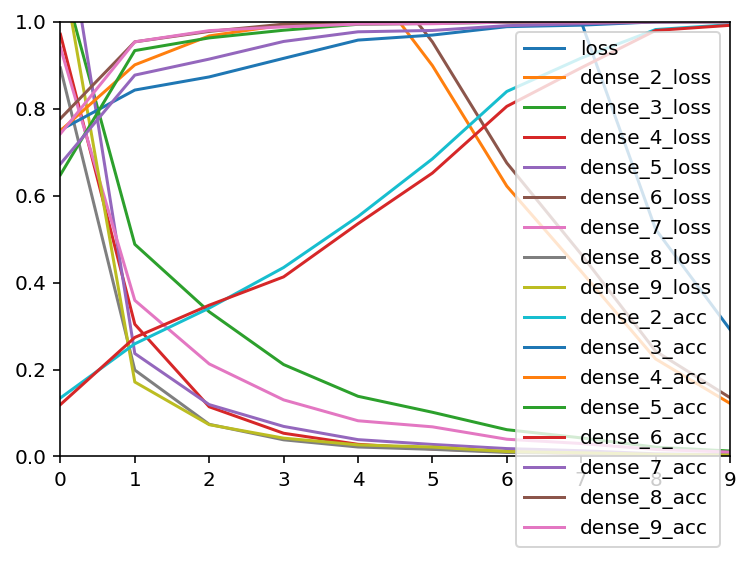

In [78]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [79]:
# Load / save

In [80]:
model.save(os.path.join("weight_save", model_name))
#model = load_model(os.path.join("weight_save", model_name))

In [50]:
# Test

In [100]:
# Build seed
idx = 6
x_test, _ = data_gen[idx]
x_test = [x_test[i][0] for i in range(len(x_test))]
x_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(x_test[0])):
        str_note = notes_vocab[track][np.argmax(x_test[4*track][i])]
        _duration = durations_vocab[track][np.argmax(x_test[4*track+1][i])]
        _offset = offsets_vocab[track][np.argmax(x_test[4*track+2][i])]
        _velocity = velocities_vocab[track][np.argmax(x_test[4*track+3][i])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = _duration
            _chord.offset = _offset
            _chord.volume.velocity = _velocity
            x_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = _duration
                _note.offset = _offset
                _note.volume.velocity = _velocity
                x_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = _duration
                _rest.offset = _offset
                x_test_stream[track].append(_rest)
    x_test_stream[track].insert(0, instru)

In [105]:
# make seq_len predictions from seed
preds = [[] for track in tracks]
x = x_test

for _ in range(seq_len):
    pred = model.predict([np.array([x[i]]) for i in range(len(x))])
    _note = [pred[i] for i in range(0, len(pred), 4)]
    _duration = [pred[i] for i in range(1, len(pred), 4)]
    _offset = [pred[i] for i in range(2, len(pred), 4)]
    _velocity = [pred[i] for i in range(3, len(pred), 4)]
    for track, _ in enumerate(tracks):
        cat_note = np.zeros((len(notes_vocab[track])))
        _note[track] = np.argmax(_note[track])
        cat_note[_note[track]] = 1
        cat_duration = np.zeros((len(durations_vocab[track])))
        _duration[track] = np.argmax(_duration[track])
        cat_duration[_duration[track]] = 1
        cat_offset = np.zeros((len(offsets_vocab[track])))
        _offset[track] = np.argmax(_offset[track])
        cat_offset[_offset[track]] = 1
        cat_velocity = np.zeros((len(velocities_vocab[track])))
        _velocity[track] = np.argmax(_velocity[track])
        cat_velocity[_velocity[track]] = 1
        
        x[4*track] = x[4*track][1:]
        x[4*track] = list(x[4*track]) + [cat_note]
        
        x[4*track+1] = x[4*track+1][1:]
        x[4*track+1] = list(x[4*track+1]) + [cat_duration]
        
        x[4*track+2] = x[4*track+2][1:]
        x[4*track+2] = list(x[4*track+2]) + [cat_offset]
        
        x[4*track+3] = x[4*track+3][1:]
        x[4*track+3] = list(x[4*track+3]) + [cat_velocity]
        
        preds[track].append((cat_note, cat_duration, cat_offset, cat_velocity))

In [106]:
# Build predicted stream
y_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(preds[track])):
        str_note = notes_vocab[track][np.argmax(preds[track][i][0])]
        _duration = durations_vocab[track][np.argmax(preds[track][i][1])]
        _offset = offsets_vocab[track][np.argmax(preds[track][i][2])]
        _velocity = velocities_vocab[track][np.argmax(preds[track][i][3])]
        
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = _duration
            _chord.offset = _offset
            _chord.volume.velocity = _velocity
            y_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = _duration
                _note.offset = _offset
                _note.volume.velocity = _velocity
                y_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = _duration
                _rest.offset = _offset
                y_test_stream[track].append(_rest)
    y_test_stream[track].insert(0, instru)

In [107]:
# play seed
x_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(x_test_stream[track])
    x_full_score.insert(0, p)
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [108]:
# play generated music
y_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(y_test_stream[track])
    y_full_score.insert(0, p)
y_full_score.write("midi", "y_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()